# Toy GWL ELO Model Notebook

## Pipeline Summary  
The basic procedures contained within the notebook

import spreadsheet -> preprocess matches (columns in toydata) ->  
create elo class -> add players for teams-> init team dicts -> bymatch: expectation, gameOver, update dicts/rating ->  
massage final results into output format -> save output -> websitey stuff

## Imports  
All of the packages that will be used in this notebook

In [3]:
#imports
import openpyxl
import pandas as pd
import requests
import json
import dataframe_image as dfi
import matplotlib.pyplot as plt
from io import BytesIO
from operator import itemgetter

## Import Spreadsheet data as a Pandas DataFrame

In [2]:
# Read in toy data spreadsheet tabs as separate dataframes in a list, season_data
spreadsheetId = "1mH_HUNLF_hj2lekOxKMOKM7RiTko4HvjdJryC5M69bM" # Please set your Spreadsheet ID.
url = "https://docs.google.com/spreadsheets/export?exportFormat=xlsx&id=" + spreadsheetId
res = requests.get(url)
data = BytesIO(res.content)
xlsx = openpyxl.load_workbook(filename=data)
season_data = []
for name in xlsx.sheetnames:
    new_df = pd.read_excel(data, sheet_name=name)
    new_df.name = name
    season_data.append(new_df)

# Need to remove some rows in the Match Records, filter via rows where matches are played
matches = season_data[0]
matches = matches[matches['Played?'] == True]
season_data[0] = matches

In [4]:
matches.head()

,Team 1,Team 2,Week,Played?,Map 1,Winner,Map 2,Winner.1,Map 3,Winner.2,Map 4,Winner.3,Map 5,Winner.4,Match Winner
0,A,B,1.0,True,Lijiang Tower,A,Dorado,A,King's Row,B,Hanamura,A,NaN,NaN,A
1,C,D,1.0,True,Lijiang Tower,D,Havana,D,Eichenwalde,C,Temple of Anubis,C,Busan,D,D
2,E,F,1.0,True,Lijiang Tower,E,Dorado,E,King's Row,E,NaN,NaN,NaN,NaN,E
3,G,H,1.0,True,Lijiang Tower,H,Havana,G,King's Row,H,Temple of Anubis,H,NaN,NaN,H
4,I,J,1.0,True,Lijiang Tower,I,Dorado,J,Eichenwalde,J,Hanamura,J,NaN,NaN,J


## Define the simple Elo model classes and functions 

In [5]:
# Define ELO model
K = 125 # ELO update scaler
Rm = 3200 # default elo initialization
delta = 500 # scaler on rel(p(win|A,B), A-B) in elo calc's exponential (Q)

class Team:
    def __init__(self, name, Rm=3200):
        self.currentRating = Rm # Current estimate elo rating
        self.opponentHist = [] # sequence of opponents (weekly)
        self.ratingHist = [] # sequence of rating estimates (weekly)
        self.currentRanking = 0 # the team's current ranking among all teams (1-10 in GWL); 0 ~ unranked
        self.rankingHist = [] # sequence of team's standing (weekly)
        
class Elo:
    def __init__(self,Rm = 3200, k=125, g=1, delta=500):
        self.ratingDict = {} # dictionary of all teams and their current ratings; redundant/will be removed. currently accessed by power_rankings()
        self.teamsDict = {} # dictionary of all team objects and their attributes. this will be used for the json output
        self.k = k # k-factor for scaling max change in rating for a match
        self.g = g # g-factor, another modifier to the rating change; will be converted to a margin of victory at a later point.
        self.rankings = {} #  dictionary of the current power rankings; written-to by power_rankings()

    def addPlayer(self,name, Rm = 3200):
        self.ratingDict[name] = Rm # update code by deleting this and subsuming into teams dict
        self.teamsDict[name] = Team(name, Rm)

    def gameOver(self, winner, loser):
        # take single game, chop up number of maps & winner of each
        # combine all updates at once
        #   expectation =  expected score | number of maps & team elos
        #   diff = total map wins (+.5 for draws) - expectation
        result = self.expectResult(self.ratingDict[winner], self.ratingDict[loser]) # compute the expected result
        
        # redundancy
        self.ratingDict[winner] = self.ratingDict[winner] + (self.k*self.g)*(1 - result)  # update elo rating based on error
        self.ratingDict[loser] 	= self.ratingDict[loser] + (self.k*self.g)*(0 - (1 -result))
        
        self.teamsDict[winner].currentRating =  self.ratingDict[winner] + (self.k*self.g)*(1 - result)
        self.teamsDict[loser].currentRating = self.ratingDict[loser] + (self.k*self.g)*(0 - (1 -result))  
        
        # update the histories
        self.teamsDict[winner].opponentHist.append(loser) # update winner's opponent
        self.teamsDict[winner].ratingHist.append(self.teamsDict[winner].currentRating) # update winner's rating history
        self.teamsDict[winner].rankingHist.append(self.teamsDict[winner].currentRanking) #  update winner's power ranking history
        self.teamsDict[loser].opponentHist.append(winner)
        self.teamsDict[loser].ratingHist.append(self.teamsDict[loser].currentRating)
        self.teamsDict[loser].rankingHist.append(self.teamsDict[loser].currentRanking)
                                                                            

    def expectResult(self, p1, p2):
        exp = (p2-p1)/delta
        return 1/((10.0**(exp))+1)
    
    def update_rankings(self):
        r = 1
        rankings  = []
        for ranking in self.power_rankings():
            team = ranking[1][0]
            self.teamsDict[team].currentRanking = r
            rankings.append(r)
            r += 1
        return rankings

    def power_rankings(self):
        self.rankings = sorted(self.ratingDict.items(), key=itemgetter(1), reverse=True)
        power = []
        for i, x in enumerate(self.rankings):
            power.append((i + 1, x))
        return power

## Model Implementation/ Testing

**MACRO TEST**


In [6]:
# initialize the elo model
GWL = Elo()

# initialize teams
teams = ['A','B','C','D','E','F','G','H','I','J']
for team in teams:
    GWL.addPlayer(team)

week = 1
for i, game in matches.iterrows():
    # Identify winner and loser
    winner = game['Match Winner']
    if game['Team 1'] == winner:
        loser = game['Team 2']
    else:
         loser = game['Team 1']
    # update elo
    GWL.gameOver(winner,loser)
    if (game['Week'] > week) or (i == len(matches)-1): # update the power rankings at the end of a week
        GWL.update_rankings()
        week +=1
#vars(GWL.teamsDict['A'])
#GWL.update_rankings()
#GWL.teamsDict['A'].rankingHist

## Output and save model results

In [7]:
# NEXT STEP: MASSAGE OUTPUT INTO FORMAT WE WANT (json)
TeamsJSON = {}
for team in GWL.teamsDict:
    teamJSON = json.dumps(GWL.teamsDict[team].__dict__)
    TeamsJSON[team] = teamJSON
TeamsJSON

{'A': '{"currentRating": 3340.813330989171, "opponentHist": ["B", "G", "D", "E", "C"], "ratingHist": [3325.0, 3352.4837500492786, 3402.1698951821977, 3229.888665325035, 3340.813330989171], "currentRanking": 4, "rankingHist": [0, 0, 2, 2, 2]}',
 'B': '{"currentRating": 3474.526922938871, "opponentHist": ["A", "C", "H", "D", "E"], "ratingHist": [3075.0, 3262.5, 3355.3219798424416, 3367.6447399704994, 3474.526922938871], "currentRanking": 1, "rankingHist": [0, 6, 6, 3, 2]}',
 'C': '{"currentRating": 2934.381475848924, "opponentHist": ["D", "B", "E", "I", "A"], "ratingHist": [3075.0, 3012.5, 3014.936731661989, 2920.7016974167414, 2934.381475848924], "currentRanking": 10, "rankingHist": [0, 7, 10, 10, 10]}',
 'D': '{"currentRating": 3219.548407452145, "opponentHist": ["C", "E", "A", "B", "J"], "ratingHist": [3325.0, 3137.5, 3105.3219798424416, 3062.677239871942, 3219.548407452145], "currentRanking": 7, "rankingHist": [0, 2, 6, 7, 8]}',
 'E': '{"currentRating": 3265.6286860651862, "opponentH

In [8]:
# To  Access the nested dicitonary requires the use of json.loads() and the team name (key) to be loaded
json.loads(TeamsJSON['A'])

{'currentRating': 3340.813330989171,
 'opponentHist': ['B', 'G', 'D', 'E', 'C'],
 'ratingHist': [3325.0,
  3352.4837500492786,
  3402.1698951821977,
  3229.888665325035,
  3340.813330989171],
 'currentRanking': 4,
 'rankingHist': [0, 0, 2, 2, 2]}

In [9]:
# write out a json file.
with open('toy_output.json', 'w') as outfile:
    json.dump(TeamsJSON,outfile)   

In [10]:
# A quick check to see that the output is correct:
with open('toy_output.json') as json_file:
    data = json.load(json_file)
    print(data)

{'A': '{"currentRating": 3340.813330989171, "opponentHist": ["B", "G", "D", "E", "C"], "ratingHist": [3325.0, 3352.4837500492786, 3402.1698951821977, 3229.888665325035, 3340.813330989171], "currentRanking": 4, "rankingHist": [0, 0, 2, 2, 2]}', 'B': '{"currentRating": 3474.526922938871, "opponentHist": ["A", "C", "H", "D", "E"], "ratingHist": [3075.0, 3262.5, 3355.3219798424416, 3367.6447399704994, 3474.526922938871], "currentRanking": 1, "rankingHist": [0, 6, 6, 3, 2]}', 'C': '{"currentRating": 2934.381475848924, "opponentHist": ["D", "B", "E", "I", "A"], "ratingHist": [3075.0, 3012.5, 3014.936731661989, 2920.7016974167414, 2934.381475848924], "currentRanking": 10, "rankingHist": [0, 7, 10, 10, 10]}', 'D': '{"currentRating": 3219.548407452145, "opponentHist": ["C", "E", "A", "B", "J"], "ratingHist": [3325.0, 3137.5, 3105.3219798424416, 3062.677239871942, 3219.548407452145], "currentRanking": 7, "rankingHist": [0, 2, 6, 7, 8]}', 'E': '{"currentRating": 3265.6286860651862, "opponentHist"

### This output looks good for a json file!

## Visualization

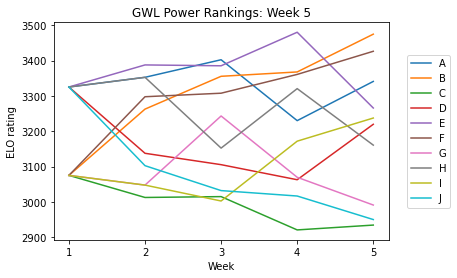

In [11]:
# Figure for Elo rating history
n_weeks =  len(GWL.teamsDict['A'].ratingHist)
title = 'GWL Power Rankings: Week {}'.format(n_weeks)
xlab = 'Week'
ylab = 'ELO rating'

for team in GWL.teamsDict:
    fig = plt.plot(GWL.teamsDict[team].ratingHist, label=team[0]); # need line colors
#to include: figure sizes
plt.title(title);
plt.xlabel(xlab);
plt.ylabel(ylab);
plt.xticks(list(range(5)),list(range(1,n_weeks+1)));
plt.legend(loc='right',bbox_to_anchor = (1.2,0.5));
#plt.savefig('elo_histories.png'); # uncomment to save figure

In [14]:
# Table for power rankings

#  First, to create a dataframe which will contain the data for the table
# initialize dataframe for 10 slots and labels 1-10, column names
power_table = pd.DataFrame(index = pd.RangeIndex(1,11,name='Rank'), columns = [' ','Team', 'ELO rating', 'dELO'])

# iterate over each team and fill in their row of the dataframe
for team in GWL.teamsDict:
    r = GWL.teamsDict[team].currentRanking # team's ranking
    rr  = power_table.loc[r] # row for team's ranking
    
    # calculate ranking change
    dr =  GWL.teamsDict[team].rankingHist[-2] - GWL.teamsDict[team].currentRanking
    
    # calculate rating change
    dELO = round(GWL.teamsDict[team].currentRating - GWL.teamsDict[team].ratingHist[-2])
    
    # update power_table with team's values
    # ranking change
    if dr > 0:
        rr[0] = '+{}'.format(dr)
    elif dr == 0:
        rr[0] = ' '
    else:
        rr[0] = dr
    # team name
    rr[1] = team
    # ELO rating
    rr[2] = round(GWL.teamsDict[team].currentRating)
    # ELO change
    if  dELO  >0:
        rr[3] = '+{}'.format(dELO)
    elif dELO  == 0:
        rr[3] = '   '
    else:
        rr[3] = dELO
df_styled = power_table.style.background_gradient(); # may want to do more  styling/sizing here and in next line
#dfi.export(df_styled,"power_rankings.png");  # uncomment to save table
df_styled

C:\Users\Rory\anaconda3\lib\site-packages\dataframe_image\_pandas_accessor.py:69: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  html = '<div>' + obj.render() + '</div>'


,,Team,ELO rating,dELO
Rank,,,,
1,+2,B,3475,+107
2,+2,F,3426,+65
3,-2,E,3266,-214
4,-2,A,3341,+111
5,,H,3161,-160
6,+3,I,3237,+65
7,,D,3220,+157
8,-2,G,2991,-79
9,-1,J,2950,-67


In [15]:
# A quick  chunk of code just to check that rankings/ratings are ok
# for team in GWL.teamsDict:
#     r = GWL.teamsDict[team].currentRanking # team's ranking
#     rr  = power_table.loc[r] # row for team's ranking
    
#     # calculate ranking change
#     dr =  GWL.teamsDict[team].rankingHist[-2] - GWL.teamsDict[team].currentRanking
    
#     # calculate rating change
#     dELO = round(GWL.teamsDict[team].currentRating - GWL.teamsDict[team].ratingHist[-2])
    
#     prior_rating = GWL.teamsDict[team].ratingHist[-2]
#     prior_rank = GWL.teamsDict[team].rankingHist[-2]
#     print('current rank: {}, '.format(r) +'prior rank: {} \n'.format(prior_rank) + 'change: {} '.format(dr) + 'len games: {}'.format(len(GWL.teamsDict[team].rankingHist)))

In [ ]:
# Next week match  preds table

In [1]:
# Create Match predictions - Map score likelihoods table, when model is updated to map  score


##  To Do's:  
- match pred this week